In [1]:
from Class import SchwarzschildPerturbation, gaussian_initial_profile
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft, fftshift, ifft, ifftshift, fftfreq
import numpy.polynomial.polynomial as poly
import scipy
from scipy import optimize

In [2]:
j = complex(0, 1)

#Parameters
M = 1
l = 2
parity = 'axial'

rstar_min = -800
rstar_max = 800
dx = 0.08

#Initialise Simulation
axial_sim = SchwarzschildPerturbation(M, l, parity, rstar_min, rstar_max, dx = 0.08, dt = 0.4*dx)

#Initial data
width = 10*M
rstar0 = 200*M
omega = 0.7
# Psi0 = np.random.randn(len(axial_sim.rstar))
# dPsi0 = np.random.randn(len(axial_sim.rstar))
Psi0 = 1/(np.sqrt(2*np.pi*width**2))*np.exp(-(axial_sim.rstar - rstar0)**2/(2*width**2))*np.exp(-j*omega*axial_sim.rstar)
dPsi0 = (-j*omega - (axial_sim.rstar - rstar0)/width**2)*Psi0

sim = axial_sim.solve(Psi0, 20000, dPsi0)
sim.make_gif(omega = omega)


Generating frames for BH_M1.0_l2_axial_w0.70_real.gif...
Compiling GIF at SS_Perturbation_gifs\BH_M1.0_l2_axial_w0.70_real.gif...
Done!


WindowsPath('SS_Perturbation_gifs/BH_M1.0_l2_axial_w0.70_real.gif')

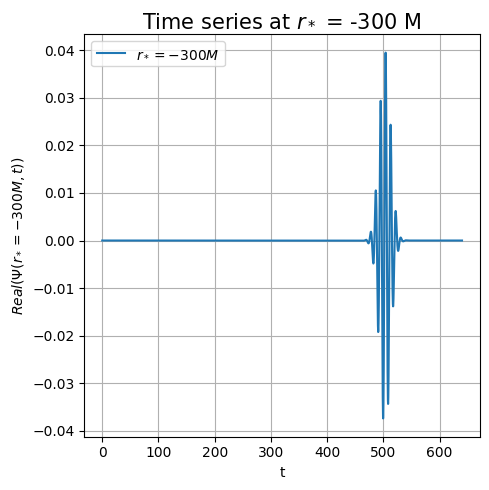

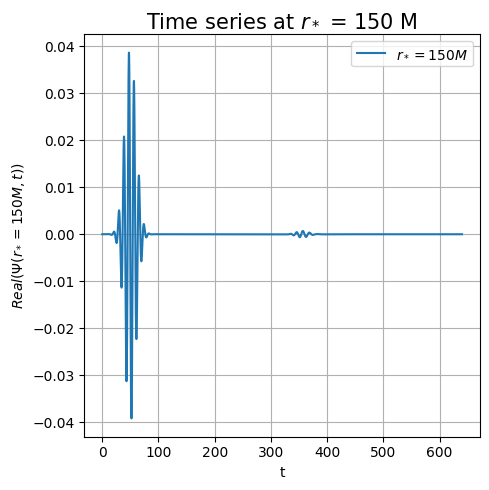

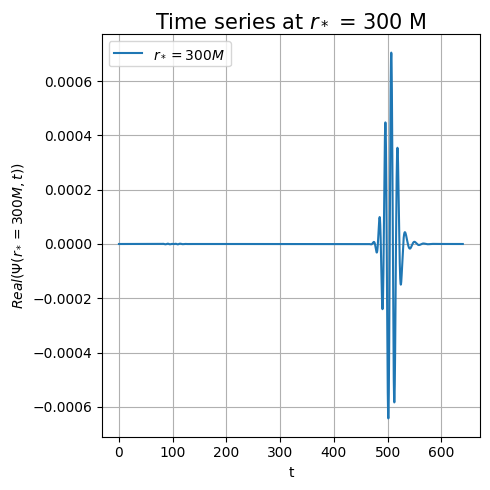

(3, 20000)


In [3]:
Psi = sim.Psi
times = sim.times

extraction_radii = [-300, 150, 300]

time_series = []

for x in extraction_radii:
    idx = np.argmin(np.abs(axial_sim.rstar - x*axial_sim.M))
    extraction = Psi[:, idx]
    time_series.append(extraction)

    plt.figure(figsize = (5, 5))
    plt.plot(times, extraction.real, label = rf'$r_* = {x} M$')
    plt.xlabel('t', fontsize = 10)
    plt.ylabel(rf'$Real(\Psi (r_*={x} M, t))$', fontsize = 10)
    plt.title(rf'Time series at $r_*$ = {x} M', fontsize = 15)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

time_series = np.array(time_series)
print(time_series.shape)

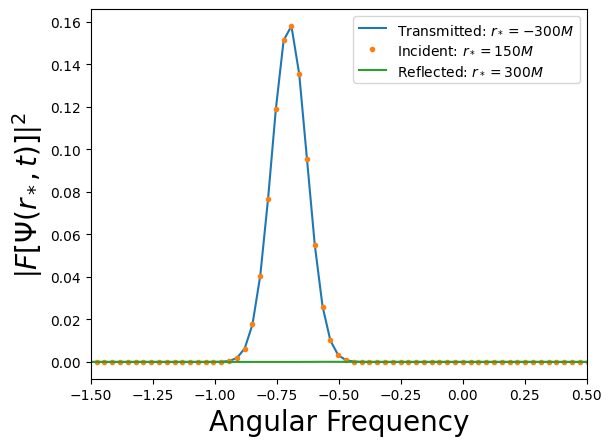

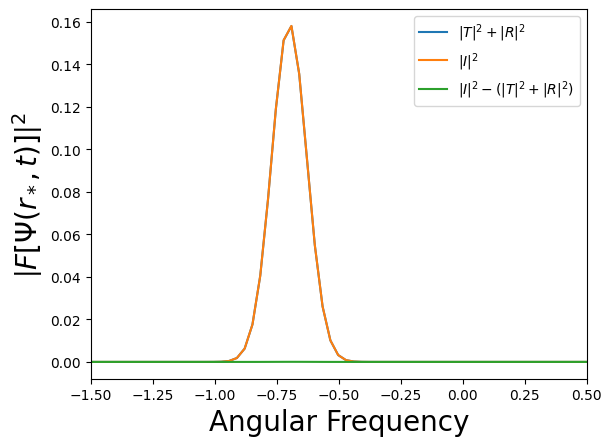

[3.97457067e-19 3.27091388e-18 3.96530239e-19 ... 3.26915217e-18
 3.99132697e-19 3.26986448e-18]


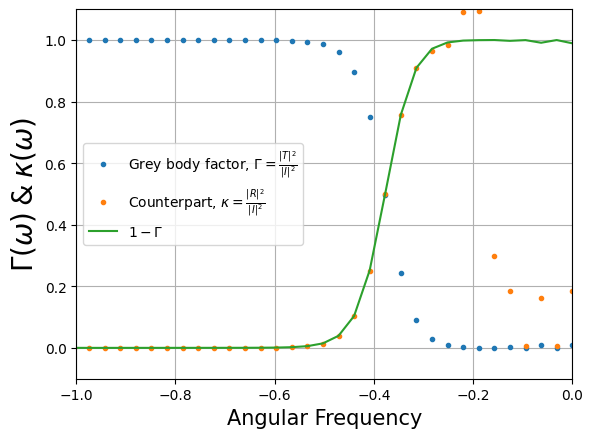

In [4]:
transmitted = time_series[0]
t_lower = np.argmin(np.abs(times - 440))
t_upper = np.argmin(np.abs(times - 650))
transmitted_windowed = transmitted[t_lower:t_upper]

incident = time_series[1]
i_lower = np.argmin(np.abs(times - 0))
i_upper = np.argmin(np.abs(times - 100))
incident_windowed = incident[i_lower:i_upper]

reflected = time_series[2]
r_lower = np.argmin(np.abs(times - 450))
r_upper = np.argmin(np.abs(times - 625))
reflected_windowed = reflected[r_lower:r_upper]

n = int(transmitted_windowed.shape[0])
q = int(incident_windowed.shape[0])
p = int(reflected_windowed.shape[0])

lengths = np.array([n, q, p])
N_fft = np.max(lengths)

transmitted_padded = np.zeros(N_fft, dtype = complex)
transmitted_padded[:n] = transmitted_windowed

incident_padded = np.zeros(N_fft, dtype = complex)
incident_padded[:q] = incident_windowed

reflected_padded = np.zeros(N_fft, dtype = complex)
reflected_padded[:p] = reflected_windowed

omega = 2*np.pi*fftfreq(N_fft, d=sim.dt)
omega = fftshift(omega)

transmitted_FT = fftshift(fft(transmitted_padded))*sim.dt/np.sqrt(2*np.pi)
transmitted_power = np.abs(transmitted_FT)**2

incident_FT = fftshift(fft(incident_padded))*sim.dt/np.sqrt(2*np.pi)
incident_power = np.abs(incident_FT)**2

reflected_FT = fftshift(fft(reflected_padded))*sim.dt/np.sqrt(2*np.pi)
reflected_power = np.abs(reflected_FT)**2


plt.figure()
plt.plot(omega, transmitted_power, label = r'Transmitted: $r_* = -300M$')
plt.plot(omega, incident_power, '.', label = r'Incident: $r_* = 150M$')
plt.plot(omega, reflected_power, label = r'Reflected: $r_* = 300M$')
plt.ylabel(r'$\left|F \left[\Psi \left( r_*, t\right)\right] \right|^2$', fontsize = 20)
plt.xlabel('Angular Frequency', fontsize = 20)
plt.xlim(-1.5, 0.5)
plt.legend()
plt.show()

plt.figure()
plt.plot(omega, reflected_power + transmitted_power, label = r'$|T|^2 + |R|^2$')
plt.plot(omega, incident_power, label = r'$|I|^2$')
plt.plot(omega, incident_power - (reflected_power + transmitted_power), label = r'$|I|^2 - (|T|^2 + |R|^2)$')
plt.ylabel(r'$\left|F \left[\Psi \left( r_*, t\right)\right] \right|^2$', fontsize = 20)
plt.xlabel('Angular Frequency', fontsize = 20)
plt.legend(loc = 'best')
plt.xlim(-1.5, 0.5)
plt.show()

print(incident_power - (reflected_power + transmitted_power))

# incident_power = transmitted_power + reflected_power
Gamma = transmitted_power/incident_power
Kappa = reflected_power/incident_power

plt.figure()
plt.plot(omega, Gamma, '.', label = r'Grey body factor, $\Gamma = \frac{|T|^2}{|I|^2}$')
plt.plot(omega, Kappa, '.', label = r'Counterpart, $\kappa = \frac{|R|^2}{|I|^2}$')
# plt.plot(omega, 16/225*omega**6, '.', label = r'Low frequency limit, $\Gamma ~ (\omega M)^6$')
plt.plot(omega, 1 - Gamma, label = r'$1 - \Gamma$') 
plt.xlabel('Angular Frequency', fontsize = 15)
plt.ylabel(r'$\Gamma (\omega) \: & \: \kappa (\omega)$', fontsize = 20)
plt.xlim(-1, 0)
plt.ylim(-0.1,1.1)
plt.grid()
plt.legend()
plt.show()

In [5]:
index = np.argmin(np.abs(Gamma - 0.5))
print(Gamma[index], omega[index])

0.4979581738767803 -0.3770514466622411


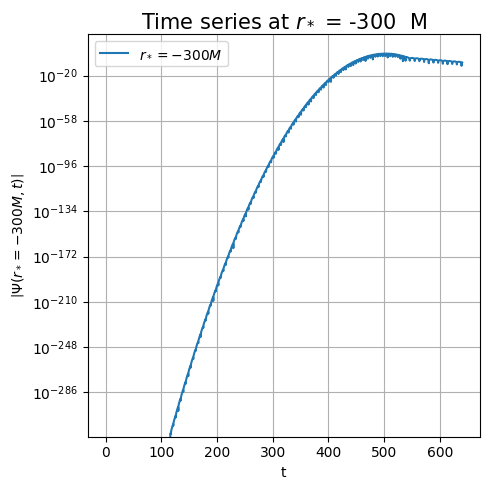

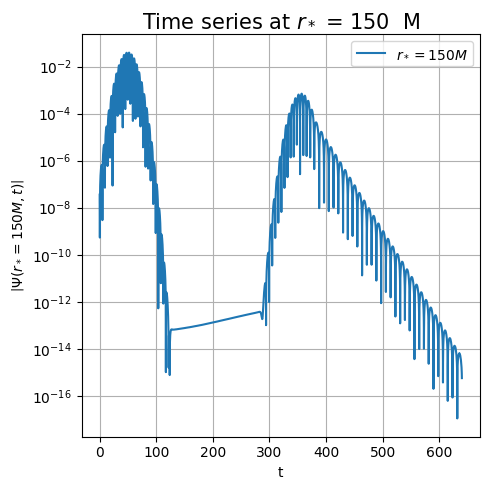

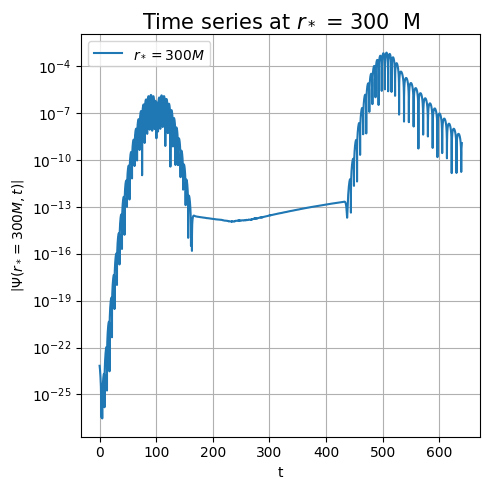

In [6]:
for i, psi in enumerate(time_series):
    plt.figure(figsize = (5, 5))
    plt.plot(times, np.abs(psi.real), label = rf'$r_* = {extraction_radii[i]} M$')
    plt.yscale('log')
    plt.xlabel('t', fontsize = 10)
    plt.ylabel(rf'$\left|\Psi (r_* = {extraction_radii[i]}  M, t)\right|$', fontsize = 10)
    plt.title(rf'Time series at $r_*$ = {extraction_radii[i]}  M', fontsize = 15)
    # plt.xlim(300, 700)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


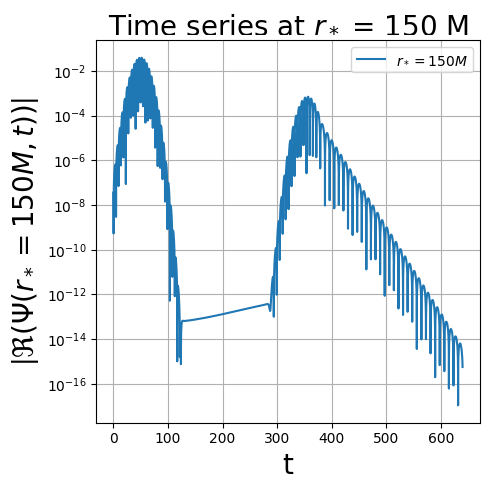

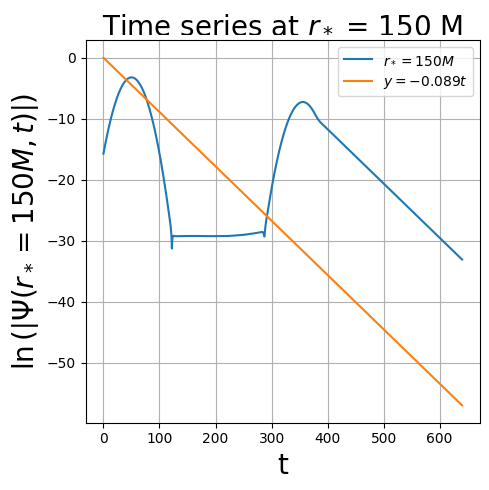

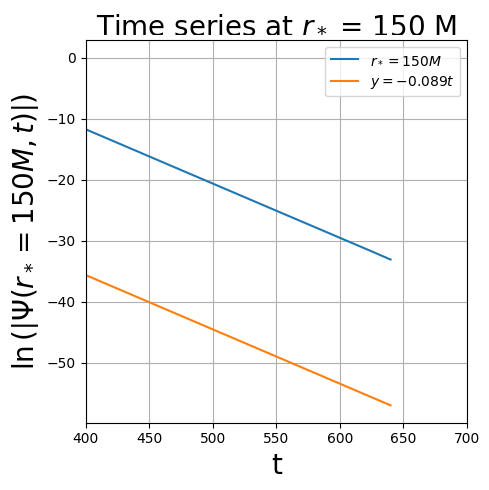

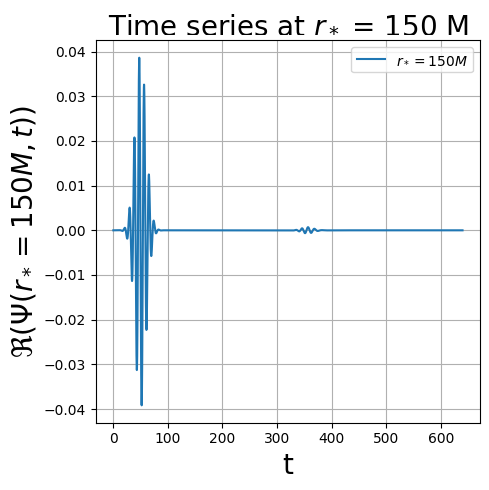

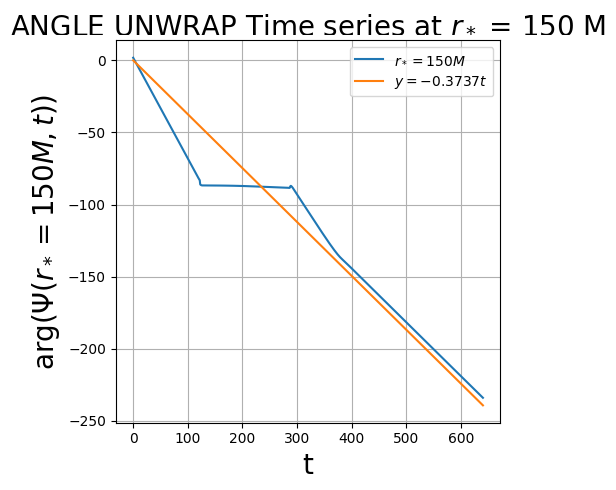

In [19]:
qnm_ts = time_series[1]
plt.figure(figsize = (5, 5))
plt.plot(times, np.abs(qnm_ts.real), label = rf'$r_* = {extraction_radii[1]} M$')
plt.yscale('log')
plt.xlabel('t', fontsize = 20)
plt.ylabel(rf'$\left|\Re \left(\Psi (r_*={extraction_radii[1]} M, t) \right) \right|$', fontsize = 20)
plt.title(rf'Time series at $r_*$ = {extraction_radii[1]} M', fontsize = 20)
# plt.xlim(300, 700)
plt.legend()
plt.grid()
plt.tight_layout()

plt.figure(figsize = (5, 5))
plt.plot(times, np.log(np.abs(qnm_ts)), label = rf'$r_* = {extraction_radii[1]} M$')
plt.plot(times, -0.089*times, label = r'$y = -0.089 t$')
plt.xlabel('t', fontsize = 20)
plt.ylabel(rf'$\ln \left(\left| \Psi (r_*={extraction_radii[1]} M, t) \right| \right)$', fontsize = 20)
plt.title(rf'Time series at $r_*$ = {extraction_radii[1]} M', fontsize = 20)
# plt.yscale('log')
# plt.xlim(400, 700)
# plt.ylim(-1e-2, 1e-2)
plt.legend()
plt.grid()
plt.tight_layout()

plt.figure(figsize = (5, 5))
plt.plot(times, np.log(np.abs(qnm_ts)), label = rf'$r_* = {extraction_radii[1]} M$')
plt.plot(times, -0.089*times, label = r'$y = -0.089 t$')
plt.xlabel('t', fontsize = 20)
plt.ylabel(rf'$\ln \left(\left| \Psi (r_*={extraction_radii[1]} M, t) \right| \right)$', fontsize = 20)
plt.title(rf'Time series at $r_*$ = {extraction_radii[1]} M', fontsize = 20)
# plt.yscale('log')
plt.xlim(400, 700)
# plt.ylim(-1e-2, 1e-2)
plt.legend()
plt.grid()
plt.tight_layout()

plt.figure(figsize = (5, 5))
plt.plot(times, qnm_ts.real, label = rf'$r_* = {extraction_radii[1]} M$')
plt.xlabel('t', fontsize = 20)
plt.ylabel(rf'$\Re \left(\Psi (r_*={extraction_radii[1]} M, t) \right)$', fontsize = 20)
plt.title(rf'Time series at $r_*$ = {extraction_radii[1]} M', fontsize = 20)
# plt.xlim(300, 700)
# plt.ylim(-1e-2, 1e-2)
plt.legend()
plt.grid()
plt.tight_layout()
    
plt.figure(figsize = (5, 5))
plt.plot(times, np.unwrap(np.angle(qnm_ts)), label = rf'$r_* = {extraction_radii[1]} M$')
plt.plot(times, -0.3737*times, label = r'$y = - 0.3737 t$')
plt.xlabel('t', fontsize = 20)
plt.ylabel(rf'$\arg (\Psi (r_*={extraction_radii[1]} M, t))$', fontsize = 20)
plt.title(rf'ANGLE UNWRAP Time series at $r_*$ = {extraction_radii[1]} M', fontsize = 20)
# plt.xlim(300, 700)
# plt.ylim(-1e-2, 1e-2)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# plt.figure(figsize = (5, 5))
# plt.plot(times, (np.abs(np.log(extraction)))**2, label = rf'$r_* = {x} M$')
# plt.plot(times[idx_t:], quadratic(times[idx_t:], 0.931, 12.6, 50, 300), label = 'Quadratic fit')
# plt.xlabel('t', fontsize = 10)
# plt.ylabel(rf'$\Psi (r_*={x} M, t)$', fontsize = 10)
# plt.title(rf'OWN WORKING Time series at $r_*$ = {x} M', fontsize = 15)
# # plt.xlim(300, 400)
# # plt.ylim(0, 400)
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()

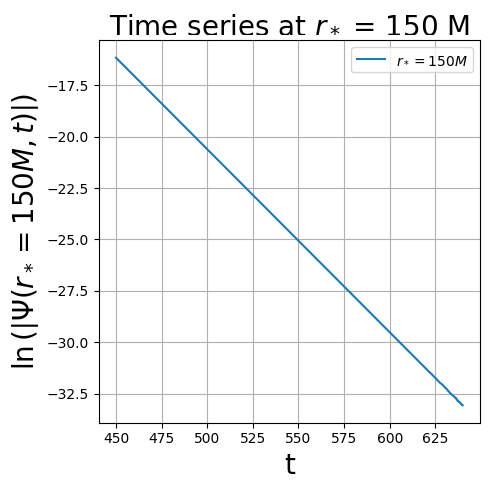

In [28]:
idx_lower = np.argmin(np.abs(times - 450))
idx_upper = np.argmin(np.abs(times - 600))

plt.figure(figsize = (5, 5))
plt.plot(times[idx_lower:], np.log(np.abs(qnm_ts[idx_lower:])), label = rf'$r_* = {extraction_radii[1]} M$')
plt.xlabel('t', fontsize = 20)
plt.ylabel(rf'$\ln \left( \left| \Psi (r_*={extraction_radii[1]} M, t) \right| \right)$', fontsize = 20)
plt.title(rf'Time series at $r_*$ = {extraction_radii[1]} M', fontsize = 20)
# plt.yscale('log')
# plt.xlim(400, 700)
# plt.ylim(-0.0002, 0.0002)
plt.legend()
plt.grid()
plt.tight_layout()

[-0.0889801  23.87747224]
[[ 5.67477581e-13 -3.09261662e-10]
 [-3.09261662e-10  1.70247633e-07]]
23434432147.090527 |C1| way too big
[7.53311078e-07 4.12610752e-04]

omega_dec =  -0.08898010068264083  +-  7.533110782313035e-07
ln|C_1| =  23.877472237052064  +-  0.0004126107521096441


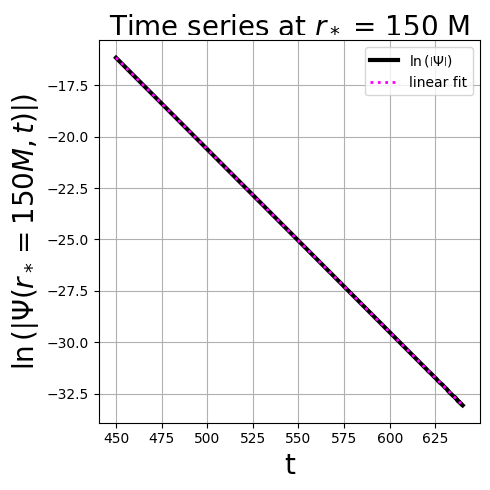

In [34]:
def linear(x, m, c):
    y = m*x + c
    return y

params_dec, params_covariance_dec = optimize.curve_fit(linear, times[idx_lower:], np.log(np.abs(qnm_ts[idx_lower:])), maxfev = 200000)
print(params_dec)
print(params_covariance_dec)
print(np.exp(params_dec[1]), '|C1| way too big')
std_err_dec = np.sqrt(np.diag(params_covariance_dec))
print(std_err_dec)
print()
print('omega_dec = ', params_dec[0], ' +- ', std_err_dec[0])
print('ln|C_1| = ', params_dec[1], ' +- ', std_err_dec[1])

plt.figure(figsize = (5, 5))
plt.plot(times[idx_lower:], np.log(np.abs(qnm_ts[idx_lower:])), linewidth = 3, color = 'k', label = rf'$\ln \left( \left| \Psi \right| \right)$')
plt.plot(times[idx_lower:], linear(times[idx_lower:], params_dec[0], params_dec[1]), linewidth = 2, linestyle = 'dotted', color = 'magenta', label = 'linear fit')
plt.xlabel('t', fontsize = 20)
plt.ylabel(rf'$\ln \left( \left| \Psi (r_*={extraction_radii[1]} M, t) \right| \right)$', fontsize = 20)
plt.title(rf'Time series at $r_*$ = {extraction_radii[1]} M', fontsize = 20)
plt.legend()
plt.grid()
plt.tight_layout()

[ -0.37364639 168.52707699]
[[ 1.24353235e-12 -6.77695289e-10]
 [-6.77695289e-10  3.73069260e-07]]
168.52707698784852 Should be ~0 if Im(C_1 = 0)
[1.11513782e-06 6.10793959e-04]

omega_dec =  -0.3736463915985869  +-  1.1151378150472278e-06
y-intercept =  168.52707698784852  +-  0.0006107939586791028
-0.3736452764607719


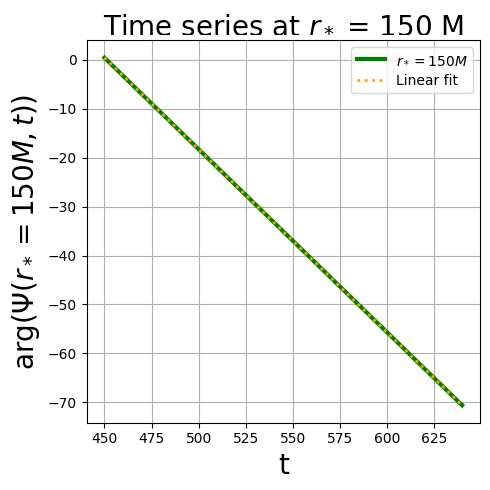

In [39]:
params_osc, params_covariance_osc = optimize.curve_fit(linear, times[idx_lower:], np.unwrap(np.angle(qnm_ts[idx_lower:])), maxfev = 200000)
print(params_osc)
print(params_covariance_osc)
print(params_osc[1], "Should be ~0 if Im(C_1 = 0)")
std_err_osc = np.sqrt(np.diag(params_covariance_osc))
print(std_err_osc)
print()
print('omega_dec = ', params_osc[0], ' +- ', std_err_osc[0])
print('y-intercept = ', params_osc[1], ' +- ', std_err_osc[1])

print(params_osc[0] + std_err_osc[0])


plt.figure(figsize = (5, 5))
plt.plot(times[idx_lower:], np.unwrap(np.angle(qnm_ts[idx_lower:])),  linewidth = 3, color = 'green', label = rf'$r_* = {extraction_radii[1]} M$')
plt.plot(times[idx_lower:], linear(times[idx_lower:], params_osc[0], params_osc[1]), linewidth = 2, linestyle = 'dotted', color = 'orange', label = 'Linear fit')
plt.xlabel('t', fontsize = 20)
plt.ylabel(rf'$\arg (\Psi (r_*={extraction_radii[1]} M, t))$', fontsize = 20)
plt.title(rf'Time series at $r_*$ = {extraction_radii[1]} M', fontsize = 20)
# plt.xlim(300, 700)
# plt.ylim(-1e-2, 1e-2)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [30]:
phi0 = (2.52452185e+02/(2*np.pi) - 40)*2*np.pi

def damped_cos(t, A, dec1, osc1, phi1):
    y = A*np.exp(-dec1*(t - 400))*np.cos(osc1*t + phi1)
    return y

def damped_sin(t, A, dec1, osc1, phi1):
    y = A*np.exp(-dec1*(t - 400))*np.sin(osc1*t + phi1)
    return y

params_real, params_covariance_real = optimize.curve_fit(damped_cos, times[idx_lower:], qnm_ts.real[idx_lower:], maxfev = 2000000)
params_imag, params_covariance_imag = optimize.curve_fit(damped_sin, times[idx_lower:], qnm_ts.imag[idx_lower:], maxfev = 2000000)

C:\Users\danie\AppData\Local\Temp\ipykernel_12124\1174575869.py:11: OptimizeWarning: Covariance of the parameters could not be estimated
  params_real, params_covariance_real = optimize.curve_fit(damped_cos, times[idx_lower:], qnm_ts.real[idx_lower:], maxfev = 2000000)
C:\Users\danie\AppData\Local\Temp\ipykernel_12124\1174575869.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  params_imag, params_covariance_imag = optimize.curve_fit(damped_sin, times[idx_lower:], qnm_ts.imag[idx_lower:], maxfev = 2000000)


In [ ]:
dt = axial_sim.dt
omega_est = -j*np.mean(np.diff(np.log(qnm_ts[idx_lower:idx_upper]))/dt)
print(omega_est)
print("Real part is way too small but gives good value for imaginary part")

(0.003349981400546508+0.08897370139359446j)


[1. 1. 1. 1.]
[1. 1. 1. 1.]


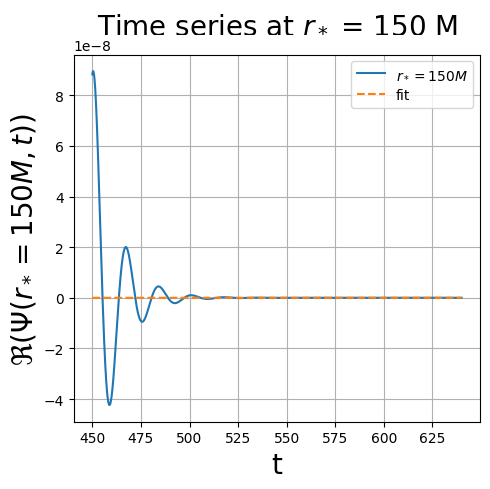

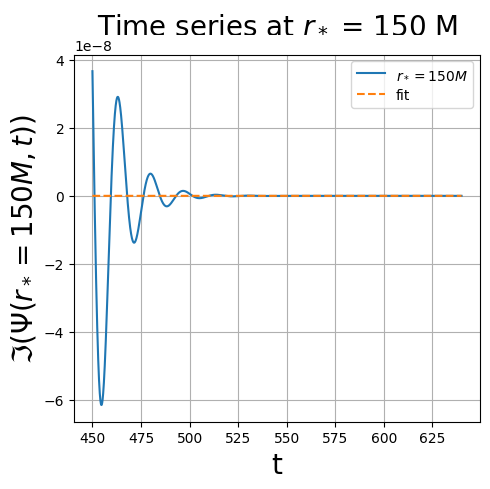

In [12]:
print(params_real)
print(params_imag)

plt.figure(figsize = (5, 5))
plt.plot(times[idx_lower:], qnm_ts.real[idx_lower:], label = rf'$r_* = {extraction_radii[1]} M$')
plt.plot(times[idx_lower:], damped_cos(times[idx_lower:], params_real[0], params_real[1], params_real[2], params_real[3]), linestyle = '--', label = 'fit')
plt.xlabel('t', fontsize = 20)
plt.ylabel(rf'$\Re \left(\Psi (r_*={extraction_radii[1]} M, t) \right)$', fontsize = 20)
plt.title(rf'Time series at $r_*$ = {extraction_radii[1]} M', fontsize = 20)
# plt.yscale('log')
# plt.xlim(400, 450)
# plt.ylim(-0.0002, 0.0002)
plt.legend()
plt.grid()
plt.tight_layout()

plt.figure(figsize = (5, 5))
plt.plot(times[idx_lower:], qnm_ts.imag[idx_lower:], label = rf'$r_* = {extraction_radii[1]} M$')
plt.plot(times[idx_lower:], damped_cos(times[idx_lower:], params_imag[0], params_imag[1], params_imag[2], params_imag[3]), linestyle = '--', label = 'fit')
plt.xlabel('t', fontsize = 20)
plt.ylabel(rf'$\Im \left(\Psi (r_*={extraction_radii[1]} M, t) \right)$', fontsize = 20)
plt.title(rf'Time series at $r_*$ = {extraction_radii[1]} M', fontsize = 20)
# plt.yscale('log')
# plt.xlim(400, 450)
# plt.ylim(-0.0002, 0.0002)
plt.legend()
plt.grid()
plt.tight_layout()

In [13]:
def fun2(t, A, osc1, dec1, phi1, B, osc2, dec2, phi2):
    y = A*np.exp(-dec1*(t - 400))*np.cos(osc1*(t) + phi1) + B*np.exp(-dec2*(t - 400))*np.cos(osc2*(t) + phi2)
    return y

nge1 = qnm_ts.real[idx_lower:] - damped_cos(times[idx_lower:], params_dcos[0], params_dcos[1], params_dcos[2], params_dcos[3])
params_nge1, params_covariance_nge1 = optimize.curve_fit(fun2, times[idx_lower:], nge1, maxfev = 2000000)

NameError: name 'params_dcos' is not defined

[-2.13286067e-07  9.36096180e-01  2.24645673e-01  2.57179667e+01
 -2.12203034e-07  9.36098221e-01  2.23743852e-01  2.25789861e+01]


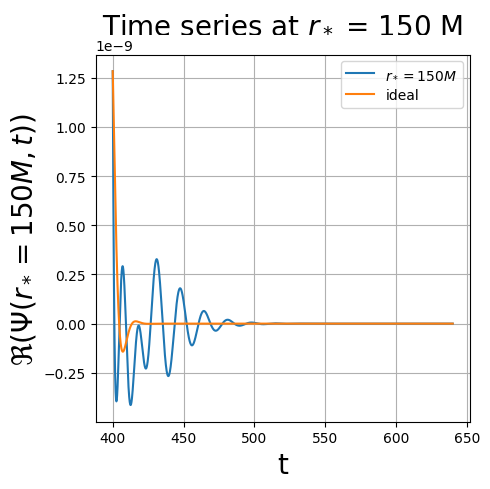

In [ ]:
#8.16481395e-06 8.89886643e-02 3.73626013e-01 2.52452185e+02
print(params_nge1)

ideal = np.max(nge1)*np.exp(-0.547830/2*(times[idx_lower:] - 400))*np.cos(0.693422/2*(times[idx_lower:] - 400))

plt.figure(figsize = (5, 5))
plt.plot(times[idx_lower:], nge1, label = rf'$r_* = {extraction_radii[1]} M$')
# plt.plot(times[idx_lower:], fun2(times[idx_lower:], params_nge1[0], params_nge1[1], params_nge1[2], params_nge1[3], params_nge1[4], params_nge1[5], params_nge1[6], params_nge1[7]), label = 'fit')
plt.plot(times[idx_lower:], ideal, label = 'ideal')
plt.xlabel('t', fontsize = 20)
plt.ylabel(rf'$\Re \left(\Psi (r_*={extraction_radii[1]} M, t) \right)$', fontsize = 20)
plt.title(rf'Time series at $r_*$ = {extraction_radii[1]} M', fontsize = 20)
# plt.yscale('log')
# plt.xlim(400, 450)
# plt.ylim(-0.0002, 0.0002)
plt.legend()
plt.grid()
plt.tight_layout()